# TD learning blind agent

in this version we only update q-values based on different rewards. that's it!

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# reading data

In [2]:

folder_path = 'data_risk_added'
dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        dataframes.append(df)


n_participant = len(dataframes)
print(f"There are {n_participant} participants.")


dataframes[0].head(5)


There are 31 participants.


,arrowRT,distribution,interTrialInterval,outcome,myCard,yourCard,spaceRT,totalReward,trialIndex,trialType,choice,block,timeoutRepeat,risk
0,570,uniform,831,lose,5,2,2209,9.5,0,response,arrowdown,1,0,0.500
1,1162,uniform,901,lose,4,3,5755,9,1,response,arrowdown,1,0,0.375
2,355,uniform,939,win,4,6,1209,9.5,2,response,arrowdown,1,0,0.375
3,1163,uniform,828,win,7,5,1997,10,3,response,arrowup,1,0,0.250
4,299,uniform,776,win,3,9,1324,10.5,4,response,arrowdown,1,0,0.250


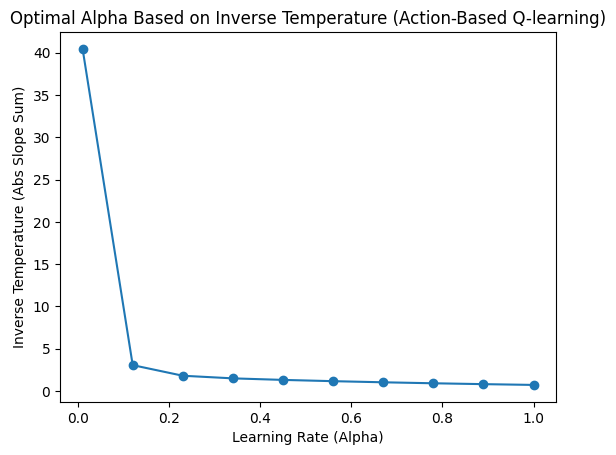

Best Alpha: 0.01, Best Inverse Temperature: 40.4418


In [ ]:
df_all = dataframes[20]
df_all = df_all[df_all['outcome'].str.lower() != 'na']  

actions = {"arrowup": 1, "arrowdown": 0}

# Initialize  q-table (considering ONLY actions)
Q_table = np.array([0.0, 0.0])  # Q-values for actions [arrowdown, arrowup]

# Hyperparameters
alphas = np.linspace(0.01, 1, 10)  # Different learning rates
best_alpha = None
best_inverse_temp = 0

# Function to train Q-learning without state-based indexing
def train_q_learning(df, alpha):
    Q_values = Q_table.copy()  # Copy Q-table
    q_value_pairs = []  # Store both Q-values for each trial
    choices = []  # Store subject's real choices

    for _, row in df.iterrows():
        action = actions[row["choice"]]  # Convert choice to 0 (arrowdown) or 1 (arrowup)
        reward = 0.5 if row["outcome"] == "win" else -0.5  # Reward directly from outcome

        # Q-learning update (no states, only actions)
        Q_values[action] += alpha * (reward - Q_values[action])

        # Store both Q-values as predictors
        q_value_pairs.append(Q_values.copy())  # Save both Q-values
        choices.append(action)

    return np.array(q_value_pairs), np.array(choices)

# Store inverse temperature results
alpha_inverse_temp = {}

# Train for each alpha and compute logistic regression slope
for alpha in alphas:
    q_values, choices = train_q_learning(df_all, alpha)

    # Prepare feature matrix: Q[0] and Q[1] as separate columns
    X = np.column_stack((q_values[:, 0], q_values[:, 1]))  # Q-values as separate predictors
    X = sm.add_constant(X)  # Add intercept term

    # Logistic Regression: Predict choice using **both Q-values as separate features**
    model = sm.Logit(choices, X).fit(disp=0)  
    
    # Extract absolute slopes (inverse temperatures for Q[0] and Q[1])
    inverse_temp = np.abs(model.params[1:]).sum()  # Sum of absolute slopes
    alpha_inverse_temp[alpha] = inverse_temp
    
    # Track best alpha based on highest inverse temperature
    if inverse_temp > best_inverse_temp:
        best_inverse_temp = inverse_temp
        best_alpha = alpha

# Plot inverse temperature vs. alpha
plt.plot(alphas, list(alpha_inverse_temp.values()), marker='o')
plt.xlabel("Learning Rate (Alpha)")
plt.ylabel("Inverse Temperature (Abs Slope Sum)")
plt.title("Optimal Alpha Based on Inverse Temperature (Action-Based Q-learning)")
plt.show()

# Print best alpha and its inverse temperature
print(f"Best Alpha: {best_alpha:.2f}, Best Inverse Temperature: {best_inverse_temp:.4f}")
